# Variational Inference - An Insight into Probabilistic Optimization

This small piece of information shall give interested people a glimpse of Variational Inference an Probabilistic Models. 
It can be seen as a small starter. The reader is going to see how to implement parameter learning with Variational Inference from scratch. In case you get more appetite take a look into the references. :)

__Contents__
1. Jumping into Probabilistic Models
2. Variational Inference
3. CAVI-Algorithm
4. Example with a Gaussian Mixture Model


## Jumping into Probabilistic Models

From this point we start with some models you may have already heard and know about. We take a slight look into them, without using some math or diving into it deeply.

### Latent Dirichlet Allocation (LDA)
LDA is a probabilistic generative model for a distribution over topics of a given corpus $D$, for every single document $\vec{w}$. A topic in turn is a distribution over words $w$. The word vector (document) is used to infer distributions for topic mixture ($\theta$) and  the topic ($z$). The model assumes a joint probability distribution $p(\theta, z, \vec{w} | \alpha, \beta )$ over all these variables and uses __approximate inference__ to compute the joint distribution. In the end each document can be characterzed using the topic mixture $\theta$.
<p align="left">
 <img src="img/lda_graphic.png">
</p>

### Variational Autoencoder (VAR)
The VAR is a Deep Generative Model. It uses deep neural network architecture, in order to explain observable data. It does so by assuming a generation of the data by a probabilistic model. The dimensionality of the latent distributions $z$ are generally smaller than the dimensionality of the feature, in order to reveal valuable information. 
<p align="left">
 <img src="img/var.png">
</p>

*Code Example:*https://graviraja.github.io/vanillavae/#

### Gaussian Mixture Model (GMM)

*Keep this in mind*

<br>The random variable $x$ is generated by a normal distribution $N(c_i^T\mu, 1)$ and is dependend from the random variables $c_i$ an $\mu$. These are random variables themselves. 
<br>The model can be described as:

\begin{align*}
\mu_k &\sim N(0, \sigma^2)            & for \ k &= 1, ..., K \\
c_i &\sim Categorical(1/K, ..., 1/K)  & for \ i &= 1, ..., n \\
x_i | c_i, \mu &\sim N(c_i^T \mu, 1)  & for \ i &= 1, ..., n
\end{align*}

<p align="left">
 <img src="img/gmm.png">
</p>



           x  labels
0  -1.816059  dist_2
1   9.882597  dist_0
2  10.070487  dist_0
3   6.514756  dist_1
4   6.834340  dist_1
Drawn means:
[ 9.67415138  6.36743812 -1.6454365  -3.01443057]


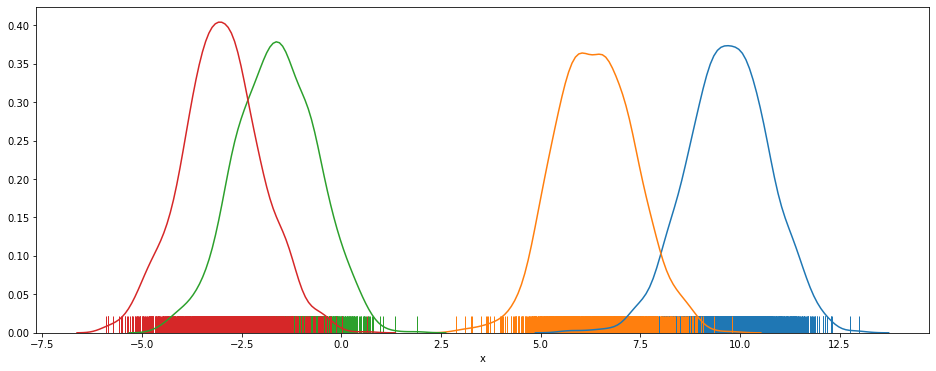

In [1]:
import numpy as np
import pandas as pd
np.random.seed(1327)
# hyperparameters of P(mu)
k = 4
mu_mean = 0
sigma = np.array([5]*k) # this variance is known


# number of instances
i = 5000
c_probas = np.array([1/k]*k)

# construct probability model
mu = np.random.normal(mu_mean, sigma, k)
c = np.random.multinomial(n=1, pvals=c_probas, size= i)
distribution_labels = [f"dist_{np.where(c[row, :] == 1)[0][0]}" for row in range(c.shape[0])]
x_mu = c.dot(mu)
x = np.array([np.random.normal(mu_value, 1, 1)[0] for mu_id, mu_value in enumerate(x_mu)])

gmm_set = pd.DataFrame({"x": x, "labels": distribution_labels})

print(gmm_set.head(5))
import seaborn as sns
import matplotlib.pyplot as plt
print(f"Drawn means:\n{mu}")
plt.figure(figsize=(16, 6))
sns.distplot(gmm_set.loc[gmm_set["labels"] == "dist_0", "x"], hist=False, rug=True)
sns.distplot(gmm_set.loc[gmm_set["labels"] == "dist_1", "x"], hist=False, rug=True)
sns.distplot(gmm_set.loc[gmm_set["labels"] == "dist_2", "x"], hist=False, rug=True)
sns.distplot(gmm_set.loc[gmm_set["labels"] == "dist_3", "x"], hist=False, rug=True)

## Variational Inference

Above models have in common the existence of __latent variables__. Latent variables are unobservable and we have few or no information about them available. By nature information about those variables are encoded in the realisations of the underlying generative process. Meaning that we can infer parameters of the latent distributions only from observations those latent disributions create. Similar problems are often encountered in bayesian statistics and were solved in the past with __markov chain Monte Carlo methods__ (Gibbs Sampling) to approximate latent distributions/posterior distributions. Their convergence generally takes very long, but is very precise. __Variational Inference (VI)__ is another approach for solving the same problem, it is __easier to scale__ and __converges faster__, but has been studied less extensively.
We use the descriped setting as a starting point for a general explanation of Variational Inference. Therefore we assume a random variable $X$ and a latent variable $Z$, which gives os the joint distribution $p(X, Z)$. In Variational Inference we are interested in the conditional density of the latent variables $p(Z | X)$.
$$
p(Z|X) = \frac{p(X, Z)}{p(X)}
$$

Unfortunately this gives us an integral, which is untractable, therefore we need approximization.

$$
p(X) = \int{p(X,Z)}dZ
$$

We are aware of the problem, therefore we define a __surrogate $q(Z) \in \mathcal{L}$__, which __approximates__ the __exact conditional $p(Z|X)$__ and gives us the best candidate. We employ the __Kullback-Leibler divergence__ (KL-divergence) to help us out. We want to find an optimal candidate $q*(z)$, which minimizes the KL-Divergence between both distributions.

$$
q^*(Z) = argmin_{q(z) \in \mathcal{L}} KL(q(Z) || p(Z|X))
$$

Unfortunately thereis a __problem__ with the __KL-Divergence__...

\begin{align*}
KL(q(Z) || p(Z|X)) & = E_q[log q(Z)] - E_q[log p(Z|X)] \\
&= E_q[log q(Z)] - E_q[log p(Z,X)] + log p(X)
\end{align*}

We can not compute the KL-Divergence so easily, because we have __the evidence__ $p(X)$. Also the Evidence is constant w.r.t. q(Z).
We therefore seek for something different, that is dependent from $q$.

\begin{align*}
log p(X) &= log \left[\int{p(X,Z)}dz \right] \\
&= log \left[ \int{p(X, Z) \frac{q(Z)}{q(Z)}dZ} \right] \\
&= log \left[ E_q \left( \frac{p(X, Z)}{q(Z)} \right) \right]
\end{align*}
Using Jensen Inequality $\phi(E[X]) \leq E[\phi(X)]$, in case we have a convex function.

\begin{align*}
log p(X) & \geq E_q \left[ log \left( \frac{p(X, Z)}{q(Z)} \right)\right] \\
ELBO(q) &= E_q[  logp(X, Z)] - E_q[  logq(Z)]
\end{align*}

The result we get here is the __Expected Lower Bound (ELBO)__, which is the first part of the KL-Divergence and the Lower Bound of the negative evidence ($- log p(X)$). If we __maximize the ELBO__, we also minimize the KL-Divergence. The relation also becomes obvious in the following:

$$
log p(X) = ELBO(q) + KL( q(Z) || p(Z | X))
$$

Thus for model selection we are going to use the Expected Lower Bound.

## Mean-Field Family

For $q(Z)$ we defined $\mathcal{L}$, which is a faimily of variational distributions. We require that family to be the __mean-field variational family__. 

$$
q(Z) = \prod_{j=1}^{m}{q_j(Z_j)}
$$

Meaning that all latent variables in that family are __independent__ from each other and each latent variable has its own variational distribution. A continous variable might therefore have a gaussian distribution and a discrete variable might have a categorical distribution.

$$
q(\mu, c) = \prod_{k=1}^K{q_k(\mu_k|m_k, s_k^2)}
$$

Therefore mean-field families are not able to capture dependencies among distributions of latent variables. Correlations can not be represented as illustrated in the following graphic.
![mean_fiel](img/mean_field.png)

## Coordinate Ascent Variational Inference (CAVI)

In this section we combine the ELBO and the mean-field family properties. We want to optimize the ELBO step by step. We will take each latent variable after the other and optimize the ELBO w.r.t. that single variable. The ELBO can thus be seen as a function of $z_j$. The ELBO can be rewritten into:

\begin{align*}
ELBO(q) &= E_q[  logp(X, Z)] - E_q[  logq(Z)] \\
&= E_q[log p(X, Z_j, Z_{-j})] - \sum_{k=1}^m E_{q_k}[q_k(Z_k)] \\
\end{align*}
Using the Law of Iterated Expectation: $E[Y] = E[E[Y|X]]$
\begin{align*}
ELBO(q_j) = E_{q_j}[E_{q_{-j}}[  log p(X, Z_j, Z_{-j})]] - E_{q_j}[logq_j(Z_j)] + const.
\end{align*}

Everything that is not dependent from $Z_j$ is pushed into the constant and the expected value is decomposed using iterative expectation.. From there we can determine the optimal $q_j^*(Z_j)$:

$$
q_j^*(Z_j) \propto exp(E_{-j}[log p(X, Z_j, Z_{-j})])
$$

The respective Algorithm written in pseudocode looks like this:

![cavi](img/cavi.png)

## Example: CAVI for a Gaussian Mixtue Model (GMM)

In this section we use the insights we generated before to apply it to the Gaussian Mixture Model. We will implement the CAVI-Algorithm from scratch. At first we are going to recall the GMM.
We described the model like this: 

\begin{align*}
\mu_k &\sim N(0, \sigma^2)            & for \ k &= 1, ..., K \\
c_i &\sim Categorical(1/K, ..., 1/K)  & for \ i &= 1, ..., n \\
x_i | c_i, \mu &\sim N(c_i^T \mu, 1)  & for \ i &= 1, ..., n
\end{align*}

![gmm](img/gmm.png)

Before we can write down the ELBO for this probability model, we have to take a look at the latent distributions. According to the mean-field family, the variational distribution for the parameters should look like this:

$$
q(Z) = \prod_{k=1}^K q(\mu_k | m_k, s_k^2) \prod_{i=1}^n q(c_i|\phi_i)
$$

We added variational parameters for each distribution, which are used to optimize the ELBO. The first part is a gaussian distribution, with $m$ as its mean and $s^2$ as its variance. The latter one given cluster assignments as probabilities over each drawn mean from the variational gaussian distribution. Each draw from this distribution is thus a k-th vecor with probability assignments for each cluster.

We now can form the ELBO for the GMM.

\begin{align*}
ELBO(m, s^2, \phi) &= \sum_{k=1}^K {E_q[log p(\mu_k) | m_k, s_k^2]} \\
&+ \sum_{i=1}^n { E_q[log p(c_i) | \phi_i] + E_q[ log p(x_i | c_i, \mu) | m, s^2]} \\
&- \sum_{i=1}^n { E_q[log q(c_i | \phi_i)]} - \sum_{k=1}^K {E_q[log q(\mu_k | m_k, s_k^2)] }
\end{align*}

For the whole example, we assume that the variance $\sigma^2$ of $p(\mu)$ is known, it is just a hyperparameter.

#### Variational Update for the Mixture Assignments

*These parts become very technical for a deeper dive take a look into the references*


From the ELBO we insert everything, for the respective parameters into the optimal variational density. We start with the mixture assignments $q(c_i | \phi_i)$. We want to get the update for the variational parameter $\phi$.

$$
q^*(c_i | \phi_i) \sim \exp( log p(c_i) + E_q[ log p(x_i | c_i, \mu) | m, s^2])
$$

To obtain the update, we have to focus on everything, that is affected by the variational parameter $\phi_{ik}$. The equation above can be decomposed. $log p(c_i)$ is a the logarithm of the prior over $c_i$, we assume an uninformitive prior, therefore the values are the same for all possibile outcomes and we can simplfy it to $-logK$. The remaining part can be simplified using the distributions and getting the expected values from it. We obtain:

$$
\phi_{ik} \sim exp( m_kx_i - (s^2 + m^2)/2)
$$

#### Variational Update for the cluster means

We start with:

$$
q(\mu_k) \sim \exp( log p(\mu_k) + \sum_{i=1}^n {E_q[log p(x_i | c_i, \mu) | \phi_i, m_{-k}, s^2_{-k}]})
$$

In [2]:
import math
from tqdm import tqdm

# ================== Initialize Variational Parameters =================
iterations = 200
# Define Prior for P
mu_p = 1
sigma_p = sigma


# Hypterparameter for Q(mu| m_q, s_q)
m_q = np.random.normal(0, 1, k)
s_q = np.ones(k)


# Hyperparameter for Q(c)
phi_q_logit = np.random.uniform(0, 1, (i,k))
phi_q = np.apply_along_axis(lambda x: x/x.sum(), 1, phi_q_logit)
c_est = phi_q

# memory
elbo_vals=[]

# Start optimization
for iter in tqdm(range(iterations)):
    # set phi_q for every kth entry
    for idx, x_i in enumerate(x):
        phi_row = np.ones(k)
        for idk in range(k):
            phi_row[idk] = math.exp(m_q[idk]*x_i - (m_q[idk]**2 + 2*s_q[idk])/2)
        phi_q[idx] = phi_row/phi_row.sum()

    for idk in range(k):
        # calculate m_q for every k
        sum_nominator = sum([phi_q[idx][idk]*x[idx] for idx, x_idx in enumerate(x)]) # check if convergence doesnt work
        sum_denominator = sum([phi_q[idx][idk] for idx, x in enumerate(x)])
        m_q[idk] = sum_nominator/(1/sigma_p[idk] + sum_denominator)

        # calculate s_q for every k
        s_q[idk] = 1/(1/sigma_p[idk] + sum_denominator)

    # ==== compute elbo
    # First Component sum_k(E[log p(mu_k)| m_k, s_k])
    e_p_mu_k = sum([m_q[idk]**2/sigma_p[idk] for idk in range(k)])
    # Second Component e_log_p(ci)
    e_log_p_c = -i*math.log(k)
    # Third Component e_log_p(xi|ci_mu)
    e_log_x = sum([sum([-phi_q[idx][idk]*x[idx]**2/2*sigma_p[idk]+phi_q[idx][idk]*x[idx]*m_q[idk]/sigma_p[idk] - phi_q[idx][idk]*m_q[idk]**2/2*sigma_p[idk] for idx, _ in enumerate(x)])
                   for idk in range(k)])
    # Forth Component e_log_q(c_i | phi_i)
    e_log_p_ci = sum([sum([phi_q[idx][idk]*math.log(phi_q[idx][idk]) for idk in range(k)]) for idx in range(i)])
    # Fith Component e_log_q_mu_k|m_k,s_k)
    e_log_mu_k_q = sum([math.log(s_q[idk])/2 for idk in range(k)]) # here it might be one according to princton
    # compute elbo
    elbo = e_p_mu_k + e_log_p_c+e_log_x - e_log_p_ci -e_log_mu_k_q
    elbo_vals.append(elbo)

    if iter>1:
        if np.abs(elbo_vals[iter-1] - elbo) < 0.01:
            print("Done!")
            break

 50%|█████     | 101/200 [00:19<00:19,  5.13it/s]

Done!


### The ELBO


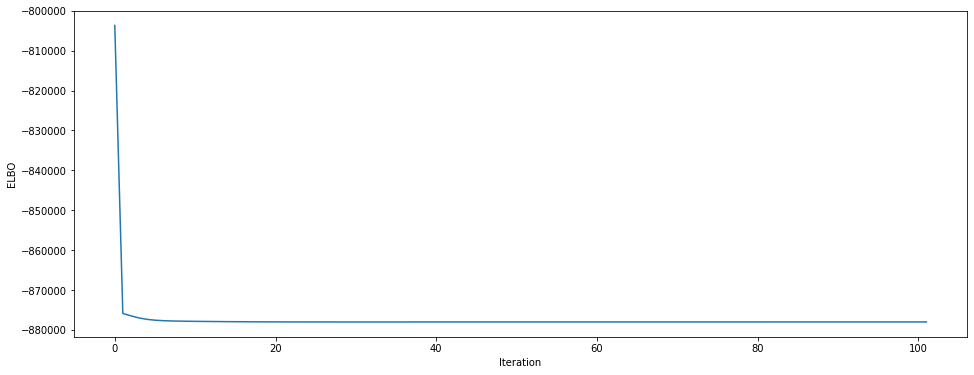

In [4]:
from utils import *
from typing import List
import plotly.express as px
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from scipy import stats
import seaborn as sns

def plot_elbo(values: List, log_vals=False):

    if log_vals:
        values = [-np.log(np.abs(value)) for value in values]
    values = pd.DataFrame({
        "Iteration": list(range(len(values))),
        "ELBO":values})
    #fig = px.line(values, x="Iteration", y="ELBO", title='Variational Inference Convergence')
    
    fig = sns.lineplot(data=values, x="Iteration", y="ELBO", markers=True, dashes=False)
    return fig
plt.figure(figsize=(16, 6))
plot_elbo(elbo_vals, False)

### Looking at the Estimates

In [17]:
from utils import *
import plotly.offline as pyo



pyo.init_notebook_mode(connected=True)
plot_dict = {"x" : x,
             "distribution": distribution_labels
             }
plot_df = pd.DataFrame.from_dict(plot_dict)
val_range = np.arange(int(round(plot_df["x"].min())), int(round(plot_df["x"].max()+1)), 0.2)
fig = px.histogram(plot_df, x="x", color="distribution", nbins=100, opacity=0.7, histnorm='probability density')
traces = [go.Scatter(x = val_range,
                     y = stats.norm(loc=m_q[idx], scale=1).pdf(val_range),
                     mode="lines",
                     name=f"estimated_dist_{idx}") for idx, _ in enumerate(plot_df["distribution"].unique().tolist())]
pyo.iplot(traces, filename = 'basic-line')
print(f"Estimated Mean Vals: {m_q}")
print(f"Actual Mean Vals: {mu}")

Estimated Mean Vals: [-2.46326181 -3.09855773 -1.36408264  8.05629035]
Actual Mean Vals: [ 9.67415138  6.36743812 -1.6454365  -3.01443057]


## TODO

1. Refactor Code + LogSum Trick
2. Generalize for Exponential Families
3. Write in Cython
4. Look into Gradient Estimators

## References


* Blei, David M., Alp Kucukelbir, and Jon D. McAuliffe. “Variational Inference: A Review for Statisticians.” Journal of the American Statistical Association 112.518 (2017)
* Blei, David M., Andrew Y. Ng, and Michael I. Jordan. "Latent dirichlet allocation." Journal of machine Learning research (2003).
* Kingma, Diederik P., and Max Welling. "Auto-encoding variational bayes." arXiv preprint arXiv:1312.6114 (2013).
* https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf
* https://zhiyzuo.github.io/VI/
* http://retiredparkingguard.com/posts/2019-06-25-variational-inference-part-1-cavi.html#org69a9b59
* https://www.cs.princeton.edu/courses/archive/fall11/cos597C/